## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

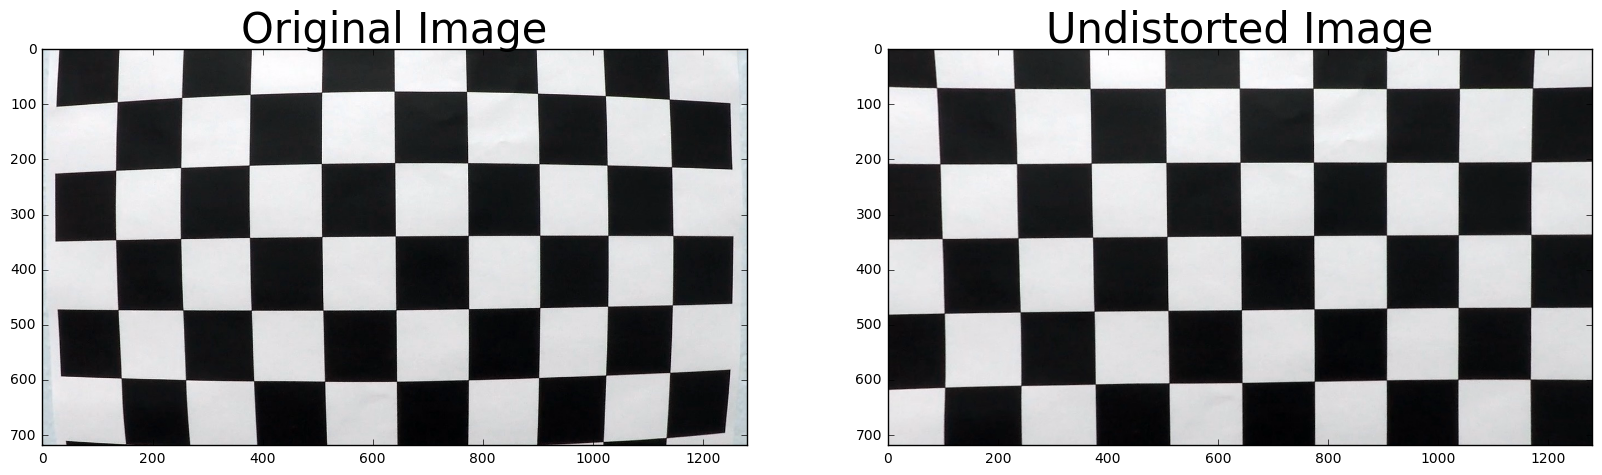

In [21]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

class Camera:
    images = glob.glob('camera_cal/calibration*.jpg')
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    def calibrate(self):
        # Step through the list and search for chessboard corners
        for fname in self.images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(self.objp)
                self.imgpoints.append(corners)

    def undistort(self,img):
        img_size = (img.shape[1], img.shape[0])
        file_name = 'calibration_'+str(img.shape[1])+str(img.shape[0]) + '.p'
        if os.path.isfile(file_name):
            with open(file_name, mode='rb') as f:
                calibtate = pickle.load(f)
            mtx, dist = train['mtx'], train['dist']
        else:
            # Do camera calibration given object points and image points
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, img_size,None,None)
            # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
            dist_pickle = {}
            dist_pickle["mtx"] = mtx
            dist_pickle["dist"] = dist
            pickle.dump( dist_pickle, open( file_name, "wb" ) )
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        return dst


camera  = Camera()
camera.calibrate()

# Test undistortion on an raw calibration image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

dst = camera.undistort(img)
cv2.imwrite('output_images/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Undistortion Example

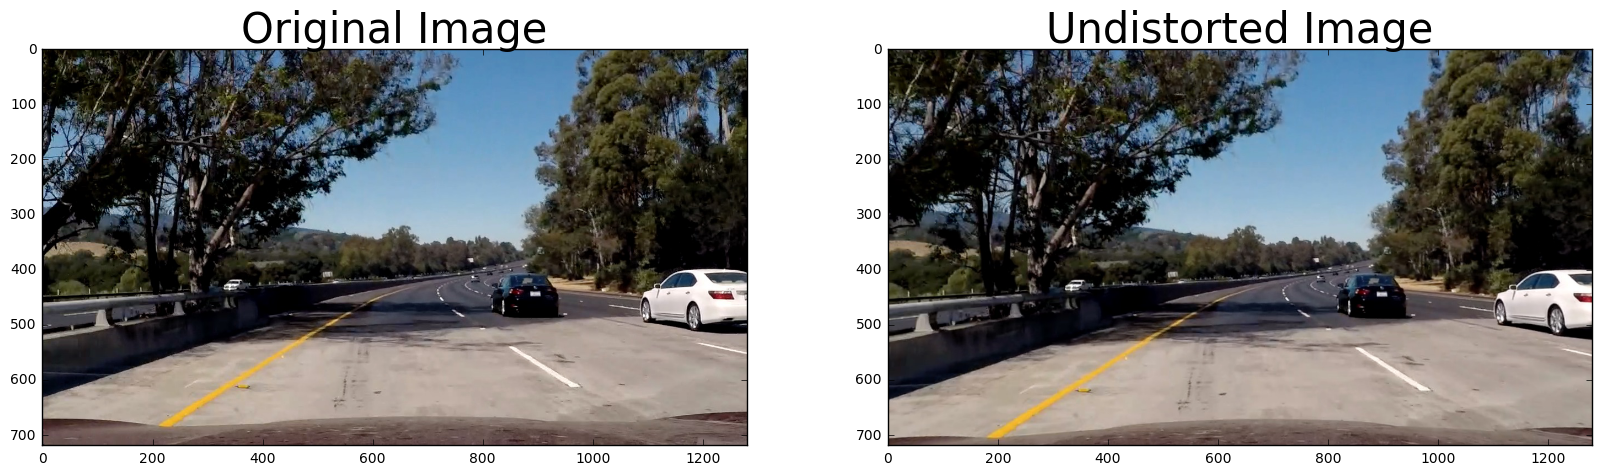

In [22]:
import matplotlib.pyplot as plt
#Test undistortion on an test image
img = plt.imread('test_images/test5.jpg')
img_size = (img.shape[1], img.shape[0])


dst = camera.undistort(img)
cv2.imwrite('output_images/test2.jpg',dst)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

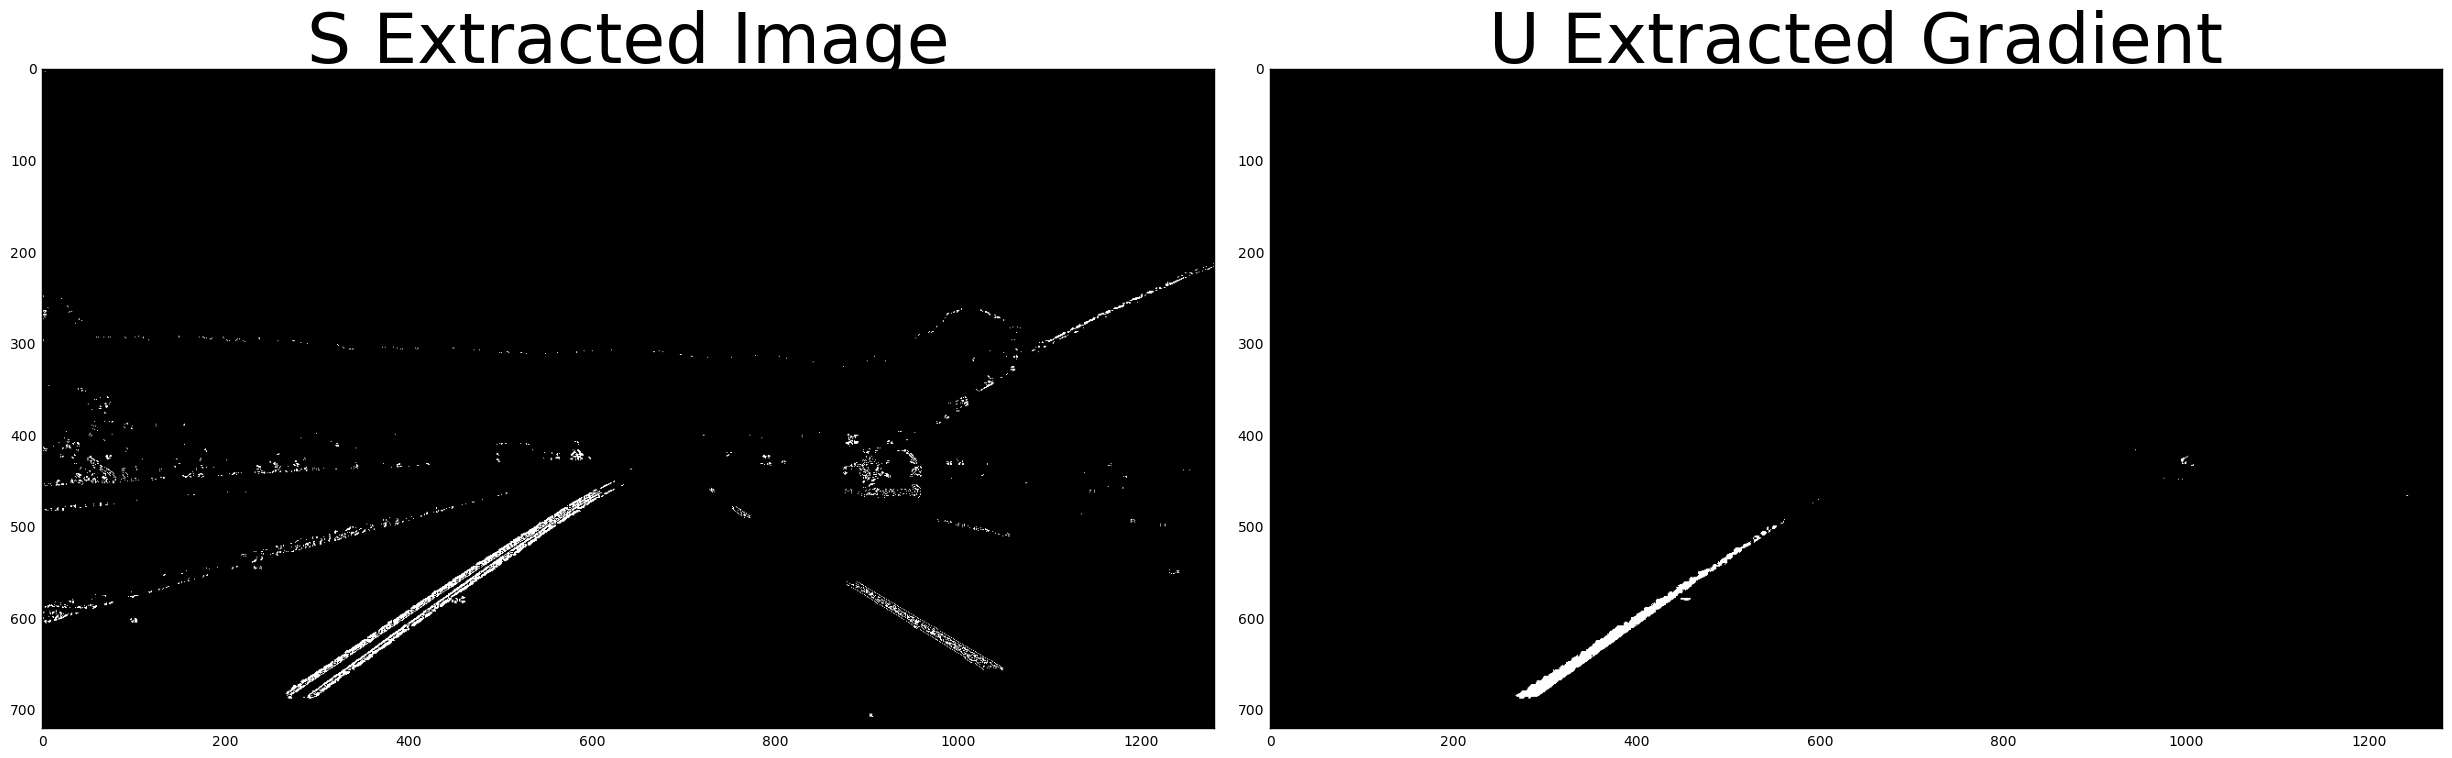

In [23]:
import matplotlib.image as mpimg
# Define a function that applies Sobel x or y,
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x',thresh=(0, 255)):
    if orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # plt.imshow(sbinary, cmap='gray')
    # 6) Return this mask as your binary_output image
    return sbinary
# Define a function that applies Sobel x and y,
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1)

    # 3) Calculate the magnitude
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    # 6) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 7) Return this mask as your binary_output image
    return binary_output

def convert2S(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    return s_channel

def convert2U(img):
    # Convert to YUV color space and separate the U channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    u_channel = hls[:, :, 2]
    return u_channel

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(direction)
    sbinary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

def combined_threshold(image):
    ksize = 3  # Choose a larger odd number to smooth gradient measurements
    gradx = abs_sobel_thresh(image, orient='x', thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=3, thresh=(0.7, 1.3))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

def extract_yellow(img):
    """
    Generates an image mask selecting yellow pixels.
    :param img: image with pixels in range 0-255
    :return: Yellow 255 not yellow 0
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (20, 50, 150), (40, 255, 255))

    return mask
# Read in an image and grayscale it
image = mpimg.imread('test_images/test3.jpg')
U_extracted = convert2U(image)
S_extracted = convert2S(image)
Y_extracted = extract_yellow(image)
# Run the function
#grad_binary = abs_sobel_thresh(U_extracted, orient='x',  thresh=(20, 100))
#mag_binary = mag_thresh(U_extracted, sobel_kernel=3, mag_thresh=(30, 100))
#dir_binary = dir_threshold(U_extracted, sobel_kernel=3, thresh=(0.7, 1.3))

combined_image_U = combined_threshold(U_extracted)

combined_image_S = combined_threshold(S_extracted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_image_S,cmap='gray')
ax1.set_title('S Extracted Image', fontsize=50)
ax2.imshow(Y_extracted, cmap='gray')
ax2.set_title('U Extracted Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

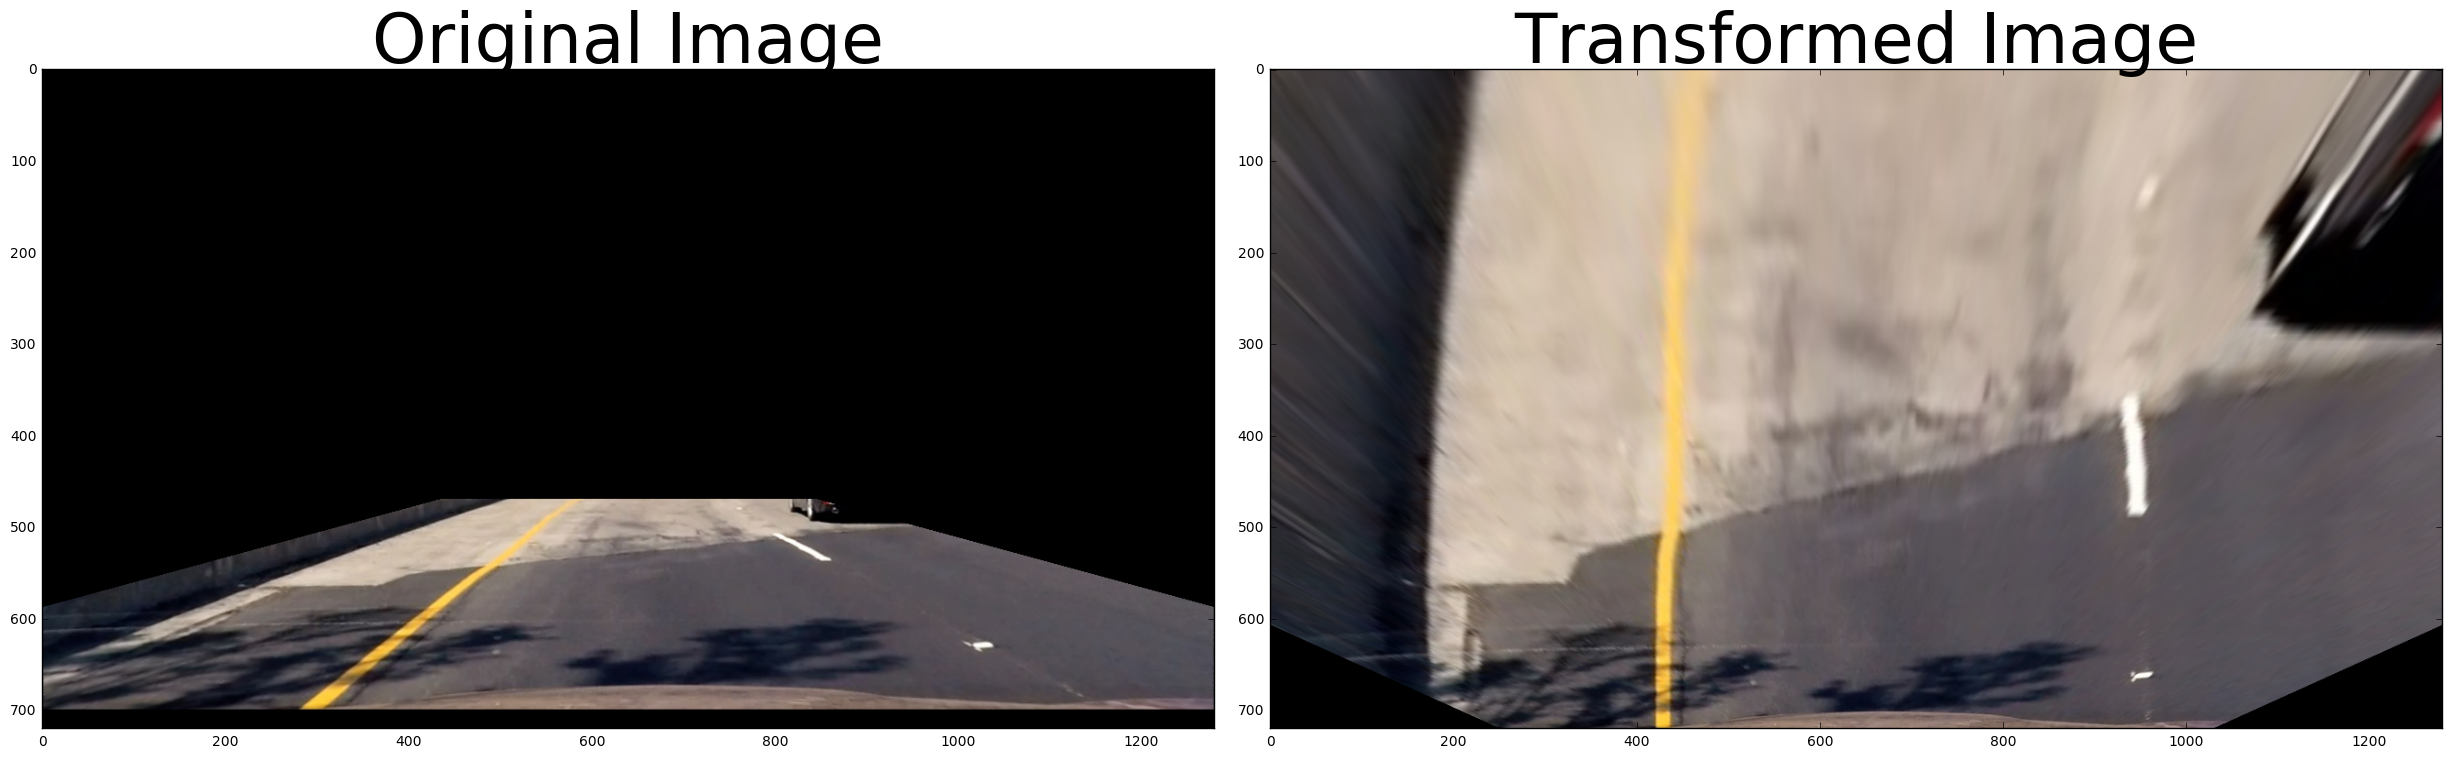

In [25]:
class PerspectiveTransform:
    src = np.float32([(130, 700),(540, 470),(740, 470),(1150, 700)])
    dst = np.float32([(330 , 720),(330 , 0),(950 , 0),(950 , 720)])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)  
    
    def get_perpective_transform(self,image):
        return cv2.warpPerspective(image, self.M, (image.shape[1],image.shape[0]), flags=cv2.INTER_LINEAR)
    
    def get_reverse_transform(self,image):
        return cv2.warpPerspective(image, self.Minv, (image.shape[1],image.shape[0]), flags=cv2.INTER_LINEAR)


image = mpimg.imread('test_images/test4.jpg')
undistorted_image = camera.undistort(image)
# Plot the result
pt = PerspectiveTransform()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(pt.get_reverse_transform(pt.get_perpective_transform(undistorted_image)),cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(pt.get_perpective_transform(undistorted_image), cmap='gray')
ax2.set_title('Transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [85]:
import numpy as np
from moviepy.video.io.VideoFileClip import VideoFileClip
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    pt = PerspectiveTransform() 
    undistordet = cv2.undistort(image, mtx, dist, None, mtx)
    warped = pt.get_perpective_transform(undistordet)
    S_extracted = convert2S(image)
    combined_image_S = combined_threshold(S_extracted)
    return combined_image_S


VIDEOS = ["project_video.mp4", "challenge_video.mp4", "harder_challenge_video.mp4"]
white_output = 'willBeDeleted2.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(get_perpective_transform) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video willBeDeleted2.mp4
[MoviePy] Writing video willBeDeleted2.mp4


100%|█████████▉| 1260/1261 [00:43<00:00, 28.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: willBeDeleted2.mp4 



In [86]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

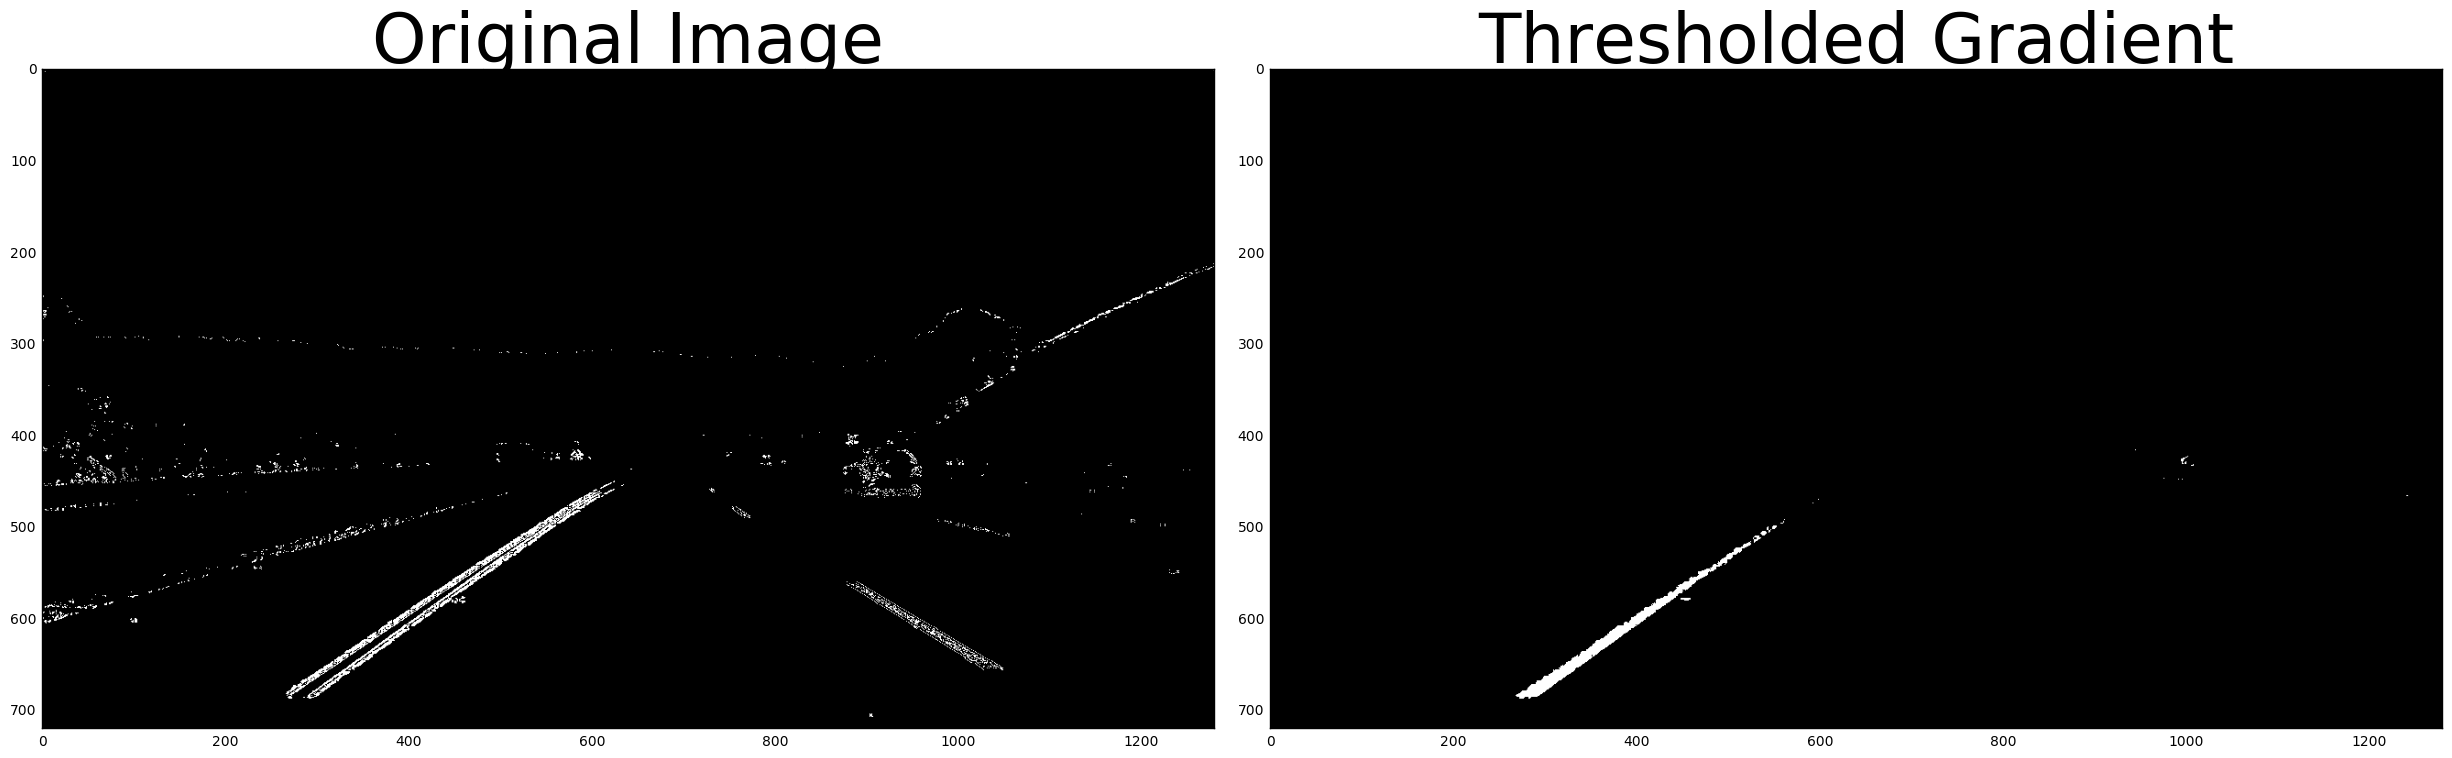

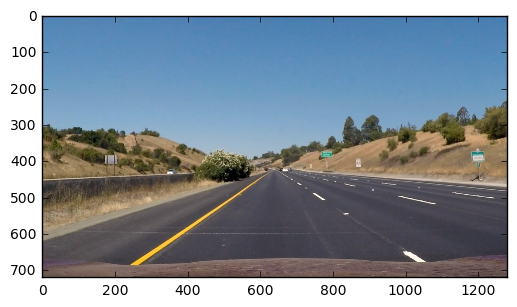

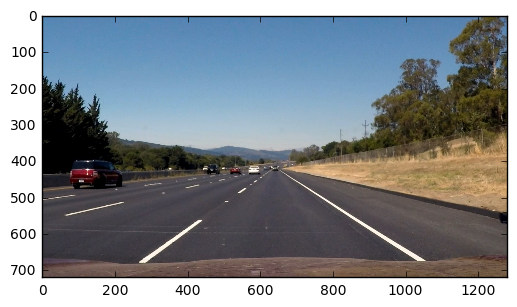

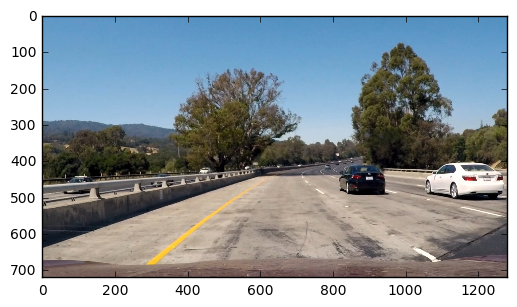

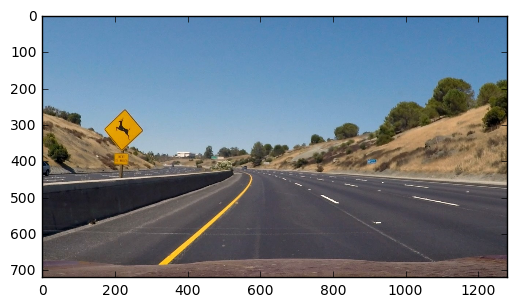

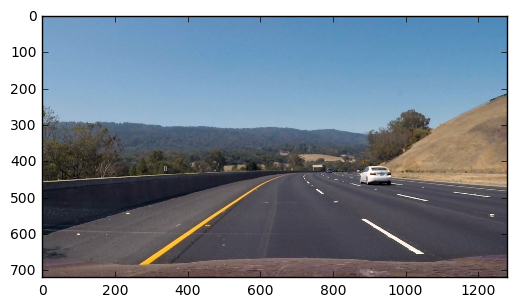

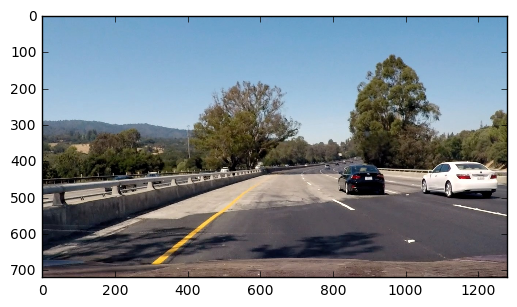

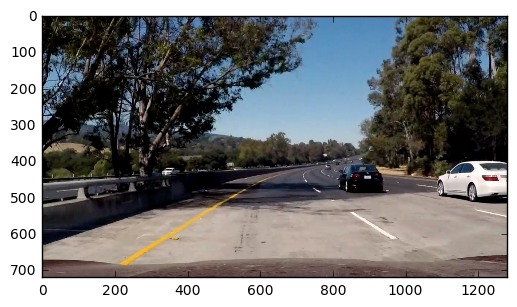

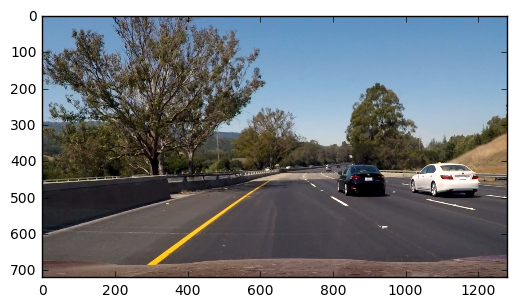

In [8]:
import os
images = []
for i in os.listdir('test_images'):
    img_path = 'test_images/' + i
    img = mpimg.imread(img_path)
    images.append(img)

for idx,image in enumerate(images):
    
    plt.figure(idx)
    plt.imshow(image)